In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import files
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms


In [2]:
# =================================
# STEP 1: UPLOAD socal2 FOLDER
# =================================
print("Upload your socal2 folder (keep CSV + images inside it)")
uploaded = files.upload()  # this uploads files, not folder

# NOTE: Colab does not allow folder direct upload using files.upload().
# We simulate by uploading a zip of folder and extracting.
# So, please right-click on socal2 folder on your PC -> "Send to ZIP"
# Then upload that socal2.zip here.

Upload your socal2 folder (keep CSV + images inside it)


Saving socal2.csv to socal2.csv


In [3]:
# =================================
# STEP 1: UPLOAD socal2 FOLDER
# =================================
print("Upload your socal2 folder (keep CSV + images inside it)")
uploaded = files.upload()  # this uploads files, not folder

# NOTE: Colab does not allow folder direct upload using files.upload().
# We simulate by uploading a zip of folder and extracting.
# So, please right-click on socal2 folder on your PC -> "Send to ZIP"
# Then upload that socal2.zip here.

Upload your socal2 folder (keep CSV + images inside it)


Saving 0.jpg to 0.jpg
Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18.jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
Saving 21.jpg to 21.jpg
Saving 22.jpg to 22.jpg
Saving 23.jpg to 23.jpg
Saving 24.jpg to 24.jpg
Saving 25.jpg to 25.jpg
Saving 26.jpg to 26.jpg
Saving 27.jpg to 27.jpg
Saving 28.jpg to 28.jpg
Saving 29.jpg to 29.jpg
Saving 30.jpg to 30.jpg
Saving 31.jpg to 31.jpg
Saving 32.jpg to 32.jpg
Saving 33.jpg to 33.jpg
Saving 34.jpg to 34.jpg
Saving 35.jpg to 35.jpg
Saving 36.jpg to 36.jpg
Saving 37.jpg to 37.jpg
Saving 38.jpg to 38.jpg
Saving 39.jpg to 39.jpg
Saving 40.jpg to 40.jpg
Saving 41.jpg to 41.jpg
Saving 42.jp

In [13]:
import pandas as pd

# Read CSV
df = pd.read_csv("/content/socal2.csv")

# Create image_name column from image_id (assuming .jpg)
df["image_name"] = df["image_id"].astype(str) + ".jpg"

# Check
print(df.head())


   image_id                 street             citi  n_citi  bed  bath  sqft  \
0         0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560   
1         1         124 C Street W      Brawley, CA      48    3   2.0   713   
2         2        2304 Clark Road     Imperial, CA     152    3   1.0   800   
3         3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
4         4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547   

    price image_name  
0  201900      0.jpg  
1  228500      1.jpg  
2  273950      2.jpg  
3  350000      3.jpg  
4  385100      4.jpg  


In [14]:
from sklearn.model_selection import train_test_split
import os

# Path to your images folder
images_dir = "/content/images"  # Change if different

# Train-test split (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Check sample
print(train_df.head())


Train size: 12379, Test size: 3095
       image_id                      street                  citi  n_citi  \
10171     10171           1806 Pinnacle Way            Upland, CA     381   
10734     10734     1072 Normandy Hill Lane         Encinitas, CA     113   
6298       6298  44596 Heritage Palms Drive             Indio, CA     154   
13474     13474           2194 Circle Drive           Cayucos, CA      72   
2664       2664      16537 Circle Hill Lane  Hacienda Heights, CA     136   

       bed  bath  sqft    price image_name  
10171    4   2.1  3404   698000  10171.jpg  
10734    5   3.0  2252  1349000  10734.jpg  
6298     2   2.0  1605   449000   6298.jpg  
13474    2   3.1  2144  1049000  13474.jpg  
2664     4   3.0  2020   788888   2664.jpg  


In [15]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class HousingDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.images_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")

        # Features (you can select numeric columns)
        features = torch.tensor([
            row["bed"],
            row["bath"],
            row["sqft"]
        ], dtype=torch.float32)

        # Target (price)
        target = torch.tensor(row["price"], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, features, target


In [17]:
from sklearn.model_selection import train_test_split

# Assuming your main dataframe is called 'df'
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


Training samples: 12379, Validation samples: 3095


In [18]:
from torch.utils.data import DataLoader
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = HousingDataset(train_df, images_dir, transform=image_transforms)
val_dataset = HousingDataset(val_df, images_dir, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
import torch.nn as nn
import torchvision.models as models
import torch

class MultiModalModel(nn.Module):
    def __init__(self, num_numeric_features):
        super(MultiModalModel, self).__init__()

        # Pretrained CNN for image
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)  # feature vector from image

        # Fully connected for numeric features
        self.fc_numeric = nn.Linear(num_numeric_features, 32)

        # Combine image + numeric features
        self.fc = nn.Sequential(
            nn.Linear(128+32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # output: price
        )

    def forward(self, image, numeric):
        img_feat = self.cnn(image)
        num_feat = self.fc_numeric(numeric)
        combined = torch.cat([img_feat, num_feat], dim=1)
        out = self.fc(combined)
        return out


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalModel(num_numeric_features=3).to(device)

criterion = nn.MSELoss()  # Regression task
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [23]:
!ls /content


0.jpg	  121.jpg  248.jpg  374.jpg  4.jpg    626.jpg  752.jpg	879.jpg
1000.jpg  122.jpg  249.jpg  375.jpg  500.jpg  627.jpg  753.jpg	87.jpg
1001.jpg  123.jpg  24.jpg   376.jpg  501.jpg  628.jpg  754.jpg	880.jpg
1002.jpg  124.jpg  250.jpg  377.jpg  502.jpg  629.jpg  755.jpg	881.jpg
1003.jpg  125.jpg  251.jpg  378.jpg  503.jpg  62.jpg   756.jpg	882.jpg
1004.jpg  126.jpg  252.jpg  379.jpg  504.jpg  630.jpg  757.jpg	883.jpg
1005.jpg  127.jpg  253.jpg  37.jpg   505.jpg  631.jpg  758.jpg	884.jpg
1006.jpg  128.jpg  254.jpg  380.jpg  506.jpg  632.jpg  759.jpg	885.jpg
1007.jpg  129.jpg  255.jpg  381.jpg  507.jpg  633.jpg  75.jpg	886.jpg
1008.jpg  12.jpg   256.jpg  382.jpg  508.jpg  634.jpg  760.jpg	887.jpg
1009.jpg  130.jpg  257.jpg  383.jpg  509.jpg  635.jpg  761.jpg	888.jpg
100.jpg   131.jpg  258.jpg  384.jpg  50.jpg   636.jpg  762.jpg	889.jpg
1010.jpg  132.jpg  259.jpg  385.jpg  510.jpg  637.jpg  763.jpg	88.jpg
1011.jpg  133.jpg  25.jpg   386.jpg  511.jpg  638.jpg  764.jpg	890.jpg
1012.jpg  1

In [24]:
images_dir = "/content"  # or the folder name you see in ls


In [25]:
import os

available_images = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]

df = df[df["image_name"].isin(available_images)]

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


Training samples: 892, Validation samples: 224


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
class HousingDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(images_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")

        features = torch.tensor([row["bed"], row["bath"], row["sqft"]], dtype=torch.float32)
        target = torch.tensor(row["price"], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, features, target


In [28]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = HousingDataset(train_df, images_dir, transform=image_transforms)
val_dataset = HousingDataset(val_df, images_dir, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [29]:
class MultiModalModel(nn.Module):
    def __init__(self, num_numeric_features):
        super(MultiModalModel, self).__init__()
        # CNN for images
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)

        # FC for numeric features
        self.fc_numeric = nn.Linear(num_numeric_features, 32)

        # Combined layers
        self.fc = nn.Sequential(
            nn.Linear(128+32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, image, numeric):
        img_feat = self.cnn(image)
        num_feat = self.fc_numeric(numeric)
        combined = torch.cat([img_feat, num_feat], dim=1)
        out = self.fc(combined)
        return out

model = MultiModalModel(num_numeric_features=3).to(device)


In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, features, targets in train_loader:
        images, features, targets = images.to(device), features.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images, features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, features, targets in val_loader:
            images, features, targets = images.to(device), features.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images, features)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch [1/10] Train Loss: 723798855992.2511 Val Loss: 698848804864.0000
Epoch [2/10] Train Loss: 723611500470.5292 Val Loss: 698663712475.4286
Epoch [3/10] Train Loss: 723422817477.4529 Val Loss: 698471364315.4286
Epoch [4/10] Train Loss: 723216914533.0225 Val Loss: 698272017846.8572
Epoch [5/10] Train Loss: 722970346941.4170 Val Loss: 697998461220.5714
Epoch [6/10] Train Loss: 722672167251.8027 Val Loss: 697646097554.2858
Epoch [7/10] Train Loss: 722311042144.4305 Val Loss: 697301214354.2858
Epoch [8/10] Train Loss: 721860480675.0134 Val Loss: 697033204882.2858
Epoch [9/10] Train Loss: 721326560646.3138 Val Loss: 696436326400.0000
Epoch [10/10] Train Loss: 720673354811.6951 Val Loss: 695911457938.2858


In [32]:
model.eval()
sample_image, sample_features, sample_target = val_dataset[0]
with torch.no_grad():
    pred = model(sample_image.unsqueeze(0).to(device), sample_features.unsqueeze(0).to(device))
print(f"Predicted price: {pred.item():.2f}, Actual price: {sample_target.item():.2f}")


Predicted price: 1530.90, Actual price: 329999.00


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


In [34]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, features, targets in val_loader:
        images, features = images.to(device), features.to(device)
        outputs = model(images, features)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(targets.numpy().flatten())


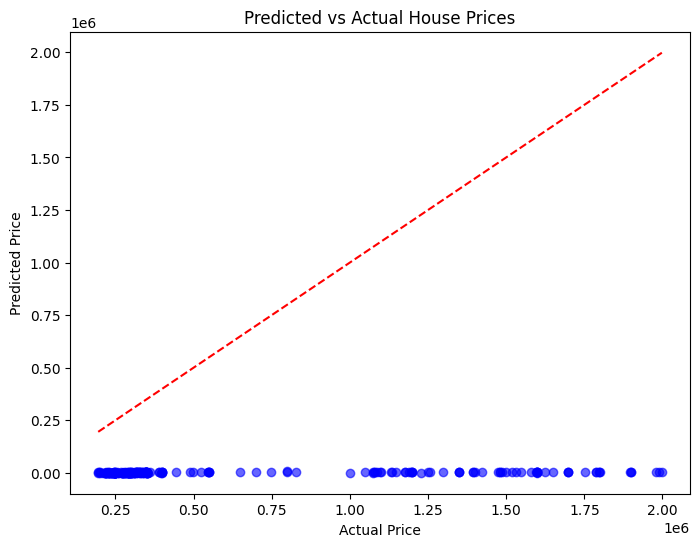

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(all_targets, all_preds, alpha=0.6, color='blue')
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')  # perfect line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual House Prices")
plt.show()
